# Biodiversity

Run the cell below to setup the notebook (_shift+return in cell to run_ or Press Run button in the menu)
Do you see a number in the left margin of the cell below? If so, click on _Kernel->Restart and Clear Output_

In [ ]:
%%capture
!pip install --no-cache-dir shapely
!pip install -U folium

%matplotlib inline
import os, time, folium, requests, json, random
import matplotlib.pyplot as plot, matplotlib as mpl
import numpy as np, pandas as pd
import ipywidgets as widgets

from matplotlib.collections import PatchCollection
from datetime import datetime
from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon

from datascience import *
from shapely import geometry as sg, wkt
from IPython.core.display import display, HTML

import httpimport
with httpimport.remote_repo(url='https://cal-icor.github.io/textbook.data/ucb/espm-105'):
    from espm_module import *

## Natural History Museums and Data Science

The goal of this notebook is to demonstrate how to access and integrate diverse data sets to visualize correlations and  patterns of species’ responses to environmental change. We will use programmatic tools (python) to show how to use Berkeley resources such as the biodiversity data from biocollections and online databases, field stations, climate models, and other environmental data. (Specifically we use data from the Berkeley Ecoengine, Cal-Adapt, and museum data via the GBIF API.)

Before we begin analyzing and visualizing biodiversity data, this introductory notebook will help familiarize you with the basics of programming in Python.

## Table of Contents

0 - [Jupyter Notebooks](#jupyter)
    
1 - [Python Basics](#basics)

2 - [GBIF API](#gbif)

3 - [Comparing California Oak Species](#oak)

4 - [Cal-Adapt API](#adapt)

## Part 0: Our Computing Environment, Jupyter notebooks  <a id='jupyter'></a>
This webpage is called a Jupyter notebook. A notebook is a place to write programs and view their results. 

### Text cells
In a notebook, each rectangle containing text or code is called a *cell*.

Text cells (like this one) can be edited by double-clicking on them. They're written in a simple format called [Markdown](http://daringfireball.net/projects/markdown/syntax) to add formatting and section headings.  You don't need to learn Markdown, but you might want to.

After you edit a text cell, click the "run cell" button at the top that looks like ▶| to confirm any changes. (Try not to delete the instructions of the lab.)

### Code cells
Other cells contain code in the Python 3 language. Running a code cell will execute all of the code it contains.

To run the code in a code cell, first click on that cell to activate it.  It'll be highlighted with a little green or blue rectangle.  Next, either press ▶| or hold down the `shift` key and press `return` or `enter`.

Try running this cell:

In [3]:
print("Hello, World!")

Hello, World!


And this one:

In [4]:
print("\N{WAVING HAND SIGN}, \N{EARTH GLOBE ASIA-AUSTRALIA}!")
print("\N{grinning face}")

👋, 🌏!
😀


## Part 1: Python basics <a id='basics'></a>
Before getting into the more high level analyses we will do on the GBIF and Cal-Adapt data, we need to cover a few of the foundational elements of programming in Python.

#### A. Expressions
The departure point for all programming is the concept of the __expression__. An expression is a combination of variables, operators, and other Python elements that the language interprets and acts upon. Expressions act as a set of instructions to be fed through the interpreter, with the goal of generating specific outcomes. See below for some examples of basic expressions. Keep in mind that most of these just map to your understanding of mathematical expressions:

In [5]:
'you' + ' and me'


'you and me'

You will notice that only the last line in a cell gets printed out. If you want to see the values of previous expressions, you need to call the `print` function on that expression. Functions use parenthesis around their parameters, just like in math!

In [6]:
print(2 + 2)

print('you' + ' and I')

print(12 ** 2)

print(6 + 4)

4
you and I
144
10


#### B. Variables
In the example below, `a` and `b` are Python objects known as __variables__. We are giving an object (in this case, an `integer` and a `float`, two Python data types) a name that we can store for later use. To use that value, we can simply type the name that we stored the value as. Variables are stored within the notebook's environment, meaning stored variable values carry over from cell to cell.

In [7]:
a = 4
b = 10/5

Notice that when you create a variable, unlike what you previously saw with the expressions, it does not print anything out.

We can continue to perform mathematical operations on these variables, which are now placeholders for what we've assigned:

In [8]:
print('a + b')

a + b


#### C. Lists
The following few cells will introduce the concept of __lists__.

A list is an ordered collection of objects. They allow us to store and access groups of variables and other objects for easy access and analysis. Check out this [documentation](https://www.tutorialspoint.com/python/python_lists.htm) for an in-depth look at the capabilities of lists.

To initialize a list, you use brackets. Putting objects separated by commas in between the brackets will add them to the list. 

In [9]:
# an empty list
lst = []
print(lst)

# reassigning our empty list to a new list
lst = [1, 3, 6, 'lists', 'are' 'fun', 4]
print(lst)

[]
[1, 3, 6, 'lists', 'arefun', 4]


To access a value in the list, put the index of the item you wish to access in brackets following the variable that stores the list. Lists in Python are zero-indexed, so the indicies for `lst` are 0, 1, 2, 3, 4, 5, and 6.

In [10]:
# Elements are selected like this:
example = lst[2]

# The above line selects the 3rd element of lst (list indices are 0-offset) and sets it to a variable named example.
print(example)

6


#### D. Dictonaries

Dictionaries are `key`-`value` pairs. Just like a word dictinary, you have a key that will index a specific definition.

In [11]:
my_dict = {'python': 'a large heavy-bodied nonvenomous constrictor snake occurring throughout the Old World tropics.'}

We can get a `value` back out by indexing the `key`:

In [12]:
my_dict['python']

'a large heavy-bodied nonvenomous constrictor snake occurring throughout the Old World tropics.'

But like real dictionaries, there can be more than one definition. You can keep a `list`, or even another dictionary within a specific `key`:

In [13]:
my_dict = {'python': ['a large heavy-bodied nonvenomous constrictor snake occurring throughout the Old World tropics.',
                      'a high-level general-purpose programming language.']}

We can index the `list` after the `key`:

In [14]:
my_dict['python'][0]

'a large heavy-bodied nonvenomous constrictor snake occurring throughout the Old World tropics.'

In [15]:
my_dict['python'][1]

'a high-level general-purpose programming language.'

---

## Part 2: GBIF API<a id='gbif'></a>

The Global Biodiversity Information Facility has an API or web service, which we can use to retrieve data. We will demonstrate several different species queries to the [GBIF Web API](http://www.gbif.org/developer/summary).

You can think of a Web API as a fancy URL for machines; what do you think the end of this URL means?

http://api.gbif.org/v1/occurrence/search?year=1800,1899

If you guessed that it limits the search to the years 1800-1899, you're right! Go ahead and click the URL above. You should see something like this:

```
{"offset":0,"limit":20,"endOfRecords":false,"count":5711947,"results":[{"key":14339704,"datasetKey":"857aa892-f762-11e1-a439-00145eb45e9a","publishingOrgKey":"6bcc0290-6e76-11db-bcd5-b8a03c50a862","publishingCountry":"FR","protocol":"BIOCASE","lastCrawled":"2013-09-07T07:06:34.000+0000","crawlId":1,"extensions":{},"basisOfRecord":"OBSERVATION","taxonKey":2809968,"kingdomKey":6,"phylumKey":7707728,"classKey":196,"orderKey":1169,"familyKey":7689,"genusKey":2849312,"speciesKey":2809968,"scientificName":"Orchis militaris L.","kingdom":"Plantae","phylum":"Tracheophyta","order":"Asparagales","family":"Orchidaceae","genus":"Orchis","species":"Orchis 
```

It might look like a mess, but it's not! This is actually very structured data, and can easily be put into a table like format, though often programmers don't do this because it's just as easy to keep it as is. If you know the structure (thanks to the DarwinCore metadata standards), you can found what you're interested in. Check out the api terms here: https://www.gbif.org/developer/occurrence#search

You might be able to pick out the curly braces `{` and think this it's a dictionary. You'd be right, except in this format we call it [JSON](https://en.wikipedia.org/wiki/JSON).

---

## *Aneides flavipunctatus*, Black Salamander

![Aneides flavipunctatus by Freiermuth](https://calphotos.berkeley.edu/imgs/512x768/0000_0000/0512/0340.jpeg)

When performing data analysis, it is always important to define a question that you seek the answer to. *The goal of finding the answer to this question will ultimately drive the queries and analysis styles you choose to use/write.*

For this example, we are going to ask: **where have [*Aneides flavipunctatus*](https://amphibiaweb.org/cgi/amphib_query?where-genus=Aneides&where-species=flavipunctatus) (the Black Salamander) been documented? Are there records at any of our field stations?**

The code to ask the API has already been written for us! This is often the case with programming, someone has already written the code, so we don't have to. We'll just set up the `GBIFRequest` object and assign that to the variable `req`, short for "request":

In [16]:
req = GBIFRequest()  # creating a request to the API

Great, so how do we make searches? We can use a Python `dictionary` to create our query parameters. We'll ask for the `scientificName` of the Black Salamander (*Aneides flavipunctatus*):

In [17]:
params = {'scientificName': 'Aneides flavipunctatus'}  # setting our parameters (the specific species we want)

Now that we have the parameters, we can feed this to our `req` variable to get back all the pages of data. We'll then make sure that each record has a `decimalLatitude`, otherwise we'll thow it out for now. Lastly, we'll print out the first five records:

In [18]:
pages = req.get_pages(params)  # using those parameters to complete the request
records = [rec for page in pages for rec in page['results'] if rec.get('decimalLatitude')]  # sift out unmapped records
records[:5]  # print first 5 records

[{'key': 5007273094,
  'datasetKey': '50c9509d-22c7-4a22-a47d-8c48425ef4a7',
  'publishingOrgKey': '28eb1a3f-1c15-4a95-931a-4af90ecb574d',
  'installationKey': '997448a8-f762-11e1-a439-00145eb45e9a',
  'hostingOrganizationKey': '28eb1a3f-1c15-4a95-931a-4af90ecb574d',
  'publishingCountry': 'US',
  'protocol': 'DWC_ARCHIVE',
  'lastCrawled': '2025-05-30T13:42:03.106+00:00',
  'lastParsed': '2025-05-30T23:49:49.805+00:00',
  'crawlId': 547,
  'extensions': {'http://rs.gbif.org/terms/1.0/Multimedia': [{'http://purl.org/dc/terms/references': 'https://www.inaturalist.org/photos/462235655',
     'http://purl.org/dc/terms/created': '2025-01-07T00:06:27Z',
     'http://rs.tdwg.org/dwc/terms/catalogNumber': '462235655',
     'http://purl.org/dc/terms/identifier': 'https://inaturalist-open-data.s3.amazonaws.com/photos/462235655/original.jpg',
     'http://purl.org/dc/terms/format': 'image/jpeg',
     'http://purl.org/dc/terms/rightsHolder': 'Stop4Snakes!',
     'http://purl.org/dc/terms/creator'

### DataFrames

JSON is great, but it might be conceptually easier to make this a table. We'll use the popular [`pandas`](http://pandas.pydata.org/) Python library. In `pandas`, a DataFrame is a table that has several convenient features. For example, we can access the columns of the table like we would `dict`ionaries, and we can also treat the columns and rows themselves as Python `list`s.

In [19]:
records_df = pd.DataFrame(records)   # converts the JSON above to a dataframe
records_df.head()  # prints the first five rows of the dataframe

,key,datasetKey,publishingOrgKey,installationKey,hostingOrganizationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,...,preparations,recordNumber,institutionID,georeferenceRemarks,county,verbatimCoordinateSystem,locality,verbatimElevation,higherClassification,collectionID
0,5007273094,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2025-05-30T13:42:03.106+00:00,2025-05-30T23:49:49.805+00:00,547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5007637661,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2025-05-30T13:42:03.106+00:00,2025-05-31T01:20:51.102+00:00,547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5006974313,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2025-05-30T13:42:03.106+00:00,2025-05-31T01:27:25.830+00:00,547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5007696395,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2025-05-30T13:42:03.106+00:00,2025-05-30T23:39:15.206+00:00,547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5007343812,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2025-05-30T13:42:03.106+00:00,2025-05-30T23:48:57.333+00:00,547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since each column (or row) above can be thought of as a `list`, that means we can use list functions to interact with them! One such function is the `len` function to get the number of elements in a `list`:

In [20]:
len(records_df.columns), len(records_df)

(108, 485)

How many columns are there? (hint: first value) How many records/rows? (hint: it's the other value)! That's a lot of information. What variables do we have in the columns?

In [21]:
records_df.columns

Index(['key', 'datasetKey', 'publishingOrgKey', 'installationKey', 'hostingOrganizationKey', 'publishingCountry', 'protocol', 'lastCrawled', 'lastParsed', 'crawlId',
       ...
       'preparations', 'recordNumber', 'institutionID', 'georeferenceRemarks', 'county', 'verbatimCoordinateSystem', 'locality', 'verbatimElevation', 'higherClassification', 'collectionID'], dtype='object', length=108)

We can use two methods from `pandas` to do a lot more. The `value_counts()` method will tabulate the frequency of the row value in a column, and the `plot.barh()` will plot us a horizontal bar chart:

In [22]:
records_df['country'].value_counts()

country
United States of America    485
Name: count, dtype: int64

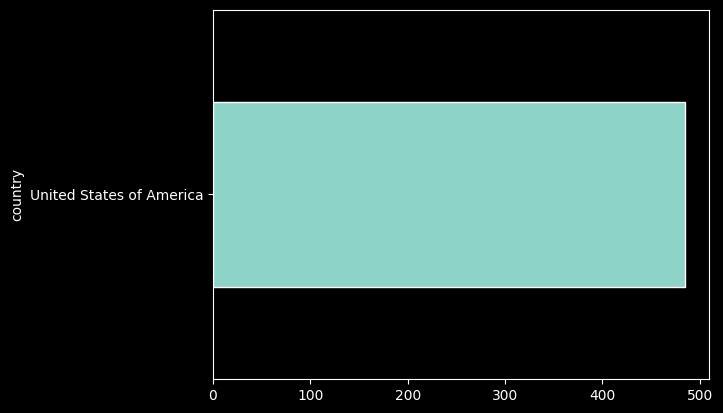

In [23]:
%matplotlib inline
records_df['country'].value_counts().plot.barh();

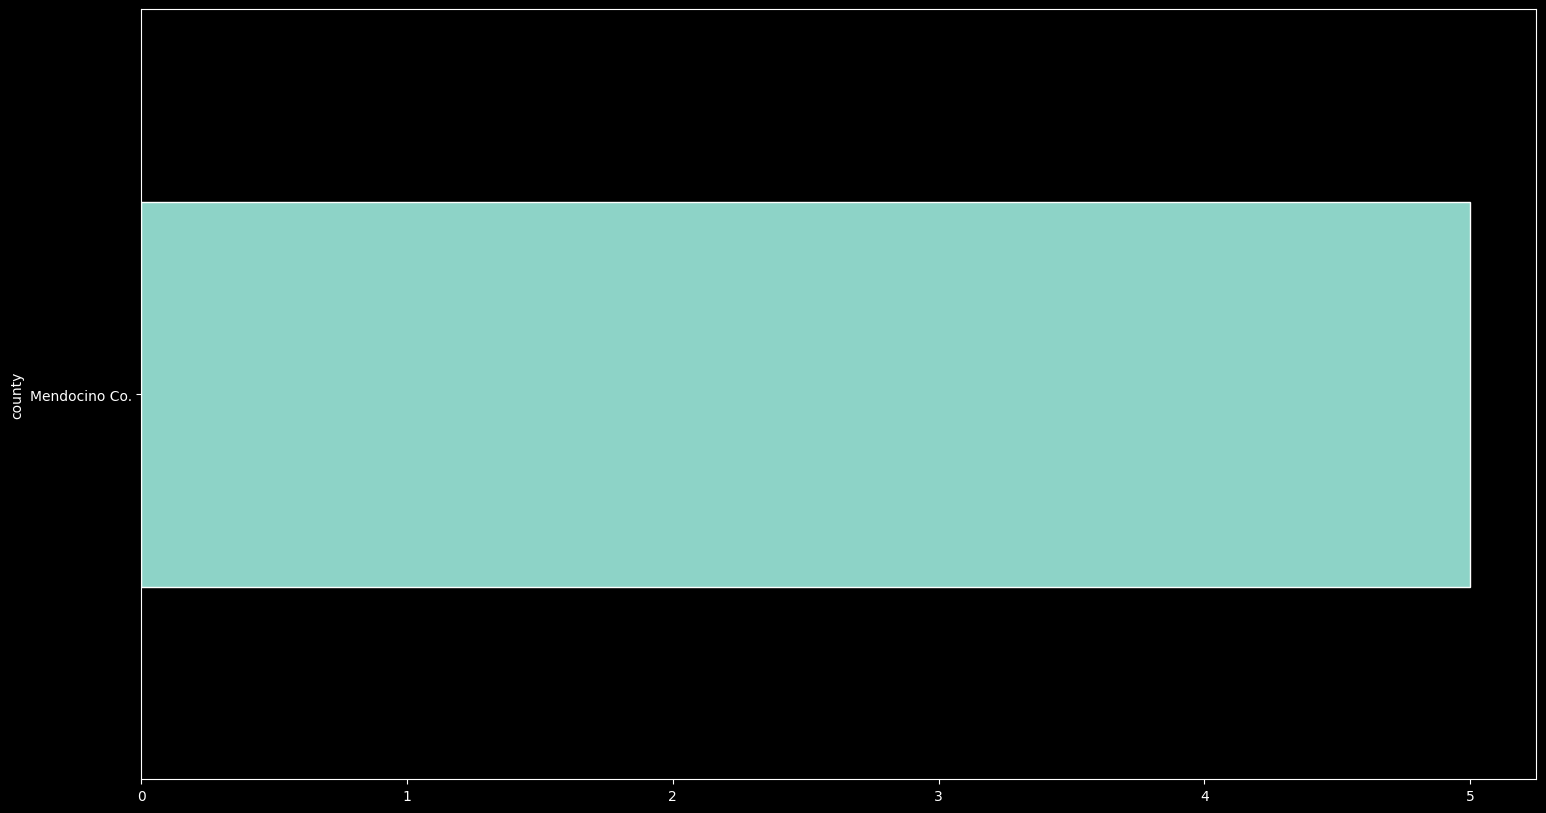

In [24]:
records_df['county'].value_counts().plot.barh(figsize=(18,10));

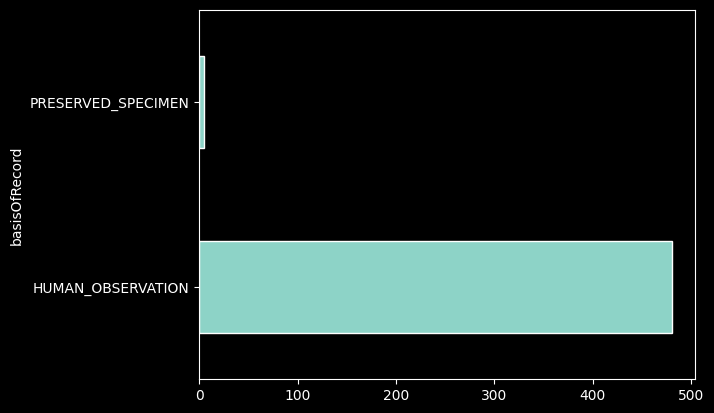

In [25]:
records_df['basisOfRecord'].value_counts().plot.barh();

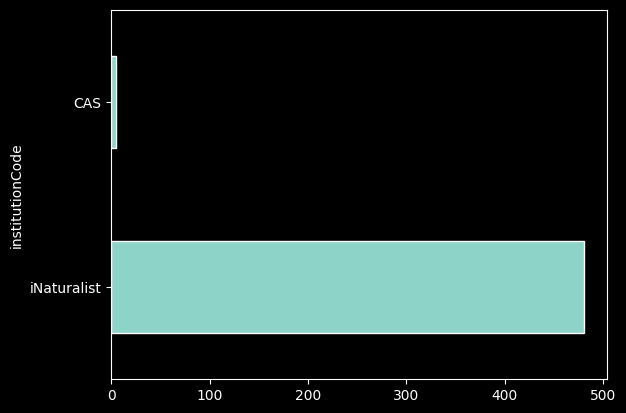

In [26]:
records_df['institutionCode'].value_counts().plot.barh();

The `groupby()` method allows us to count based one column based on another, and then color the bar chart differently depending on a variable of our choice:

In [27]:
records_df.groupby(["institutionCode", "basisOfRecord"])['basisOfRecord'].count()

institutionCode  basisOfRecord     
CAS              PRESERVED_SPECIMEN      5
iNaturalist      HUMAN_OBSERVATION     480
Name: basisOfRecord, dtype: int64

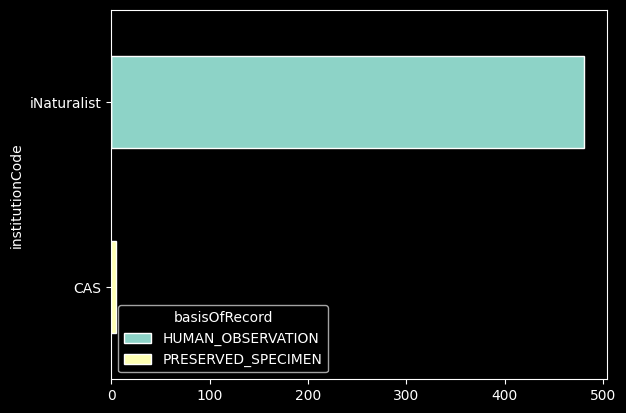

In [28]:
records_df.groupby(["institutionCode", "basisOfRecord"])['basisOfRecord'].count().unstack().plot.barh(stacked=True);

And we can use `plot.hist()` to make a histogram:

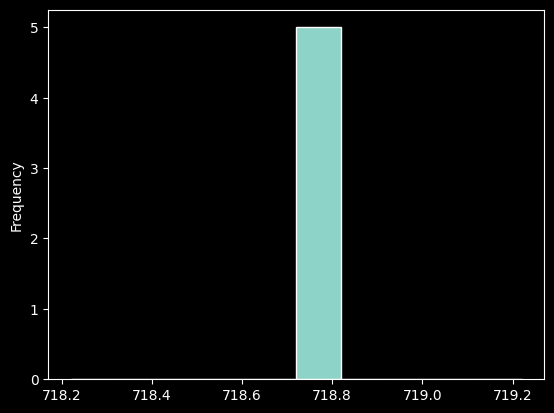

In [29]:
records_df['elevation'].plot.hist();

<div class="alert alert-info">
Question: What does the above plot tell us about the elevation range of this species? In other words is this likely a low elevation species or montane? Type your response below in the blank cell.
    </div>

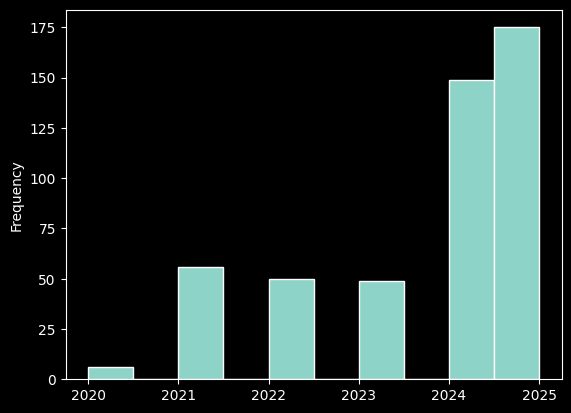

In [30]:
#When were these records collected?
records_df['year'].plot.hist();

---

### Mapping

Now we can map our latitude and longitude points. We'll want to color code by `institutionCode` so we can see which collection made the observation or has the specimen. We'll use a function that does this automatically, and it will randomly generate a color-- so if you don't like the colors you see, try running the cell again!

In [31]:
color_dict, html_key = assign_colors(records_df, "institutionCode")
display(HTML(html_key))

institutionCode,HEX,Color
iNaturalist,HEX,
CAS,HEX,


In [32]:
#Did you get an error in the last cell? If so you may have a corrupt or old variable so please run this cell
#to re-run your original search
#If you did not get an error, skip this cell and keep going!

my_req = GBIFRequest()  # creating a request to the API
my_params = {'scientificName': 'Aneides flavipunctatus'}  # setting our parameters (the specific species we want)
my_pages = my_req.get_pages(my_params)  # using those parameters to complete the request
my_records = [rec for page in my_pages for rec in page['results'] if rec.get('decimalLatitude')]  # sift out valid records
records_df = pd.DataFrame(my_records) 

color_dict, html_key = assign_colors(records_df,'institutionCode');
display(HTML(html_key))

institutionCode,HEX,Color
iNaturalist,HEX,
CAS,HEX,


Now we can map the points!

In [ ]:
mapa = folium.Map(location=[37.359276, -122.179626], zoom_start=5) # Folium is a useful library for generating
                                                                   # Google maps-like map visualizations.
for r in records_df.iterrows():
    lat = r[1]['decimalLatitude']
    long = r[1]['decimalLongitude']
    folium.CircleMarker((lat, long), color=color_dict[r[1]['institutionCode']], popup=r[1]['basisOfRecord']).add_to(mapa)
mapa

---

To get the boundries for all the reserves, we will need to send a request to get GeoJSON, which is a format for encoding a variety of geographic data structures. With this code, we can request GeoJSON for all reserves and plot ocurrences of the species. First we'll assign the API URL that has the data to a new variable `url`:

In [ ]:
url = 'https://ecoengine.berkeley.edu/api/layers/reserves/features/'

Now we make the requests just like we did earlier through the GBIF:

In [ ]:
# NOTE: The following cell and any cells relying on the reserves variable will not work, as the EcoEngine API has been deprecated.
# A data request to the EcoEngine team is in progress to receive the data, and will be updated in the future.
# If this comment is still present, data has not yet been obtained; we recommend you skip to section 3.
reserves = requests.get(url, params={'page_size': 30}).json()
reserves

If you look closely, this is just bounding boxes for the latitude and longitude of the reserves.

There are some reserves that the EcoEngine didn't catch, we'll add the information for "Blodgett", "Hopland", and "Sagehen":

In [ ]:
station_urls = {
    'Blodgett': 'https://raw.githubusercontent.com/BNHM/spatial-layers/master/wkt/BlodgettForestResearchStation.wkt',
    'Hopland': 'https://raw.githubusercontent.com/BNHM/spatial-layers/master/wkt/HoplandResearchAndExtensionCenter.wkt',
    'Sagehen': 'https://raw.githubusercontent.com/BNHM/spatial-layers/master/wkt/SagehenCreekFieldStation.wkt'
}
reserves['features'] += [{'type': "Feature", 'properties': {"name": name}, 'geometry': mapping(wkt.loads(requests.get(url).text))}
                for name, url in station_urls.items()]

We can see all the station names by indexing the `name` value for the reserves:

In [ ]:
[r['properties']['name'] for r in reserves['features']]

We can send this `geojson` directly to our mapping library `folium`. You'll have to zoom in, but you should see blue outlines areas, there are the reserves!:

In [ ]:
mapb = folium.Map(location=[37.359276, -122.179626], zoom_start=5) 

wkt = folium.features.GeoJson(reserves)
mapb.add_child(wkt)
for r in records_df.iterrows():
    lat = r[1]['decimalLatitude']
    long = r[1]['decimalLongitude']
    folium.CircleMarker((lat, long), color=color_dict[r[1]['institutionCode']], popup=r[1]['basisOfRecord']).add_to(mapb)
mapb

---

We can also find out which stations have how many our species. First we'll have to add a column to our `DataFrame` that makes points out of the latitude and longitude coordinates:

In [ ]:
def make_point(row):
    return Point(row['decimalLongitude'], row['decimalLatitude'])

records_df["point"] = records_df.apply(lambda row: make_point (row),axis=1)

Now we can write a little function to check whether that point is in one of the stations, and if it is, we'll add that station in a new column called `station`:

In [ ]:
def in_station(reserves, row):
    
    reserve_polygons = []

    for r in reserves['features']:
        name = r['properties']['name']
        poly = sg.shape(r['geometry'])
        reserve_polygons.append({"id": name,
                                 "geometry": poly})
    
    sid = False
    for r in reserve_polygons:
        if r['geometry'].contains(row['point']):
            sid = r['id']
            sid = r['id']
    if sid:
        return sid
    else:
        return False

Now apply this function to the `DataFrame`:

In [ ]:
records_df["station"] = records_df.apply(lambda row: in_station(reserves, row),axis=1)
in_stations_df = records_df[records_df["station"] != False]
len(in_stations_df.columns), len(in_stations_df)

<div class="alert alert-info">
Question: How many species records occur at one of the field stations or reserves? (write your answer in the blank cell below)
    </div>

Let's see if this corresponds to what we observed on the map:

In [ ]:
in_stations_df.groupby(["species", "station"])['station'].count().unstack().plot.barh(stacked=True)

<div class="alert alert-info">
**Exercise**
Edit the code below to search for a different species (replace the scientificName value of 'Melanerpes formicivorus') with another you're interested in, then adapt some of the graphing cells above to explore your data! Use the examples from previous cells to copy and paste the code. Try the California Newt "Taricha torosa"!
</div>

In [ ]:
my_req = GBIFRequest()  # creating a request to the API
my_params = {'scientificName': 'Melanerpes formicivorus', 'basisOfRecord':'Preserved_Specimen'}  # search parameters (requesting a species and only Preserved specimens to filter out all the observations)
my_pages = my_req.get_pages(my_params)  # using those parameters to complete the request
my_records = [rec for page in my_pages for rec in page['results'] if rec.get('decimalLatitude')]  # sift out valid records
my_records_df = pd.DataFrame(my_records)  # make a dataframe
my_records_df.tail()  # print last 5 rows

len(my_records_df)

In [ ]:
color_dict, html_key = assign_colors(my_records_df, "institutionCode")
display(HTML(html_key))

In [ ]:
mapc = folium.Map([37.359276, -122.179626], zoom_start=5)

points = folium.features.GeoJson(reserves)
mapc.add_child(points)
for r in my_records_df.iterrows():
    lat = r[1]['decimalLatitude']
    long = r[1]['decimalLongitude']
    folium.CircleMarker((lat, long), color=color_dict[r[1]['institutionCode']]).add_to(mapc)
mapc

To see if your search results occur on a field station, run the following cells

In [ ]:
def make_point(row):
    return Point(row['decimalLongitude'], row['decimalLatitude'])

my_records_df["point"] = my_records_df.apply(lambda row: make_point (row),axis=1)

In [ ]:
my_records_df["station"] = my_records_df.apply(lambda row: in_station(reserves, row),axis=1)
in_stations_df = my_records_df[my_records_df["station"] != False]
len(in_stations_df.columns), len(in_stations_df)

How many records occur in field reserves according to the number of records above?

In [ ]:
in_stations_df.groupby(["species", "station"])['station'].count().unstack().plot.barh(stacked=True)
in_stations_df.head() 

---

<div class="alert alert-info">
**Exercise**: Edit the code to search for other species, map the records and see if you can find specimens from field reserves. See if you can figure which code snippets you would use to see which field reserves have these records. Which code snippets would you use to plot other aspects of these records?
</div>

---

## Part 3: Comparing California Oak species:<a id='oak'></a>


| ![quercus douglassi](https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/Large_Blue_Oak.jpg/220px-Large_Blue_Oak.jpg)  | ![quercus lobata](https://upload.wikimedia.org/wikipedia/commons/thumb/8/86/Valley_Oak_Mount_Diablo.jpg/220px-Valley_Oak_Mount_Diablo.jpg) | ![quercus durata](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/Quercusduratadurata.jpg/220px-Quercusduratadurata.jpg) | ![quercus agrifolia](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d1/Quercus_agrifolia_foliage.jpg/220px-Quercus_agrifolia_foliage.jpg) |
|:---:|:---:|:---:|:---:|
| *Quercus douglassi* | *Quercus lobata* | *Quercus durata* | *Quercus agrifolia*|


California has high species diversity in its native oaks. Let's search for these four species of oak using our `GBIF` API function and collect the observations:

In [ ]:
species_records = []

species = ["Quercus douglasii", "Quercus lobata", "Quercus durata", "Quercus agrifolia"]

for s in species:
    req = GBIFRequest()  # creating a request to the API
    params = {'scientificName': s}  # setting our parameters (the specific species we want)
    pages = req.get_pages(params)  # using those parameters to complete the request
    records = [rec for page in pages for rec in page['results'] if rec.get('decimalLatitude')]  # sift out valid records
    species_records.extend(records)
    time.sleep(3)

We can convert this JSON to a `DataFrame` again:

In [ ]:
records_df = pd.DataFrame(species_records)
records_df.head()

How many records do we have now?

In [ ]:
len(records_df)

Let's see how they're distributed among our different species queries:

In [ ]:
%matplotlib inline
records_df['scientificName'].value_counts().plot.barh()

We can group this again by `collectionCode`:

In [ ]:
records_df.groupby(["scientificName", "collectionCode"])['collectionCode'].count().unstack().plot.barh(stacked=True)

We can also map these like we did with the first species search above:

In [ ]:
color_dict, html_key = assign_colors(records_df, "species")
display(HTML(html_key))

In [ ]:
mapc = folium.Map([37.359276, -122.179626], zoom_start=5)

points = folium.features.GeoJson(reserves)
mapc.add_child(points)
for r in records_df.iterrows():
    lat = r[1]['decimalLatitude']
    long = r[1]['decimalLongitude']
    folium.CircleMarker((lat, long), color=color_dict[r[1]['species']]).add_to(mapc)
mapc

We can use the same code we wrote earlier to see which reserves have which species of oak:

In [ ]:
records_df["point"] = records_df.apply(lambda row: make_point (row),axis=1)
records_df["station"] = records_df.apply(lambda row: in_station(reserves, row),axis=1)
in_stations_df = records_df[records_df["station"] != False]
in_stations_df.head()

Now we can make a bar graph like we did before, grouping by `species` and stacking the bar based on `station`:

In [ ]:
in_stations_df.groupby(["species", "station"])['station'].count().unstack().plot.barh(stacked=True)

<div class="alert alert-info">
Question: Searching and mapping multiple species can be useful. Which species would you expect to find at more than one field station? Besides multiple species of *Quercus* which co-occur, what other combination of species might be useful to search and visualize their data in this way? Write your response in the cell below.
</div>

#### ---

## Part 4: Cal-Adapt API<a id='adapt'></a>
<a target=_blank href="https://calphotos.berkeley.edu/cgi/img_query?enlarge=0000+0000+0715+1756"> ![California Damsels dragonfly](https://calphotos.berkeley.edu/imgs/128x192/0000_0000/0715/1756.jpeg)</a>Let's work with California Damsels dragonfly (*Argia agrioides*) data from the GBIF API and climate data from Cal-Adapt. (image from CalPhotos)

In [ ]:
req = GBIFRequest()  # creating a request to the API
params = {'scientificName': 'Argia agrioides'}  # setting our parameters (the specific species we want)
pages = req.get_pages(params)  # using those parameters to complete the request
records = [rec for page in pages for rec in page['results'] if rec.get('decimalLatitude')]  # sift out valid records
records[:5]  # print first 5 records

We'll make a `DataFrame` again for later use:

In [ ]:
records_df = pd.DataFrame(records)
records_df.head()

Now we will use the [Cal-Adapt](http://api.cal-adapt.org/api/) web API to work with time series raster data. It will request an entire time series for any geometry and return a Pandas `DataFrame` object for each record in all of our *Argia agrioides* records:

In [ ]:
req = CalAdaptRequest()
records_g = [dict(rec, geometry=sg.Point(rec['decimalLongitude'], rec['decimalLatitude']))
             for rec in records]
ca_df = req.concat_features(records_g, 'gbifID')

Let's look at the first five rows:

In [ ]:
ca_df.head()

In [ ]:
len(ca_df.columns), len(ca_df)

This looks like the time series data we want for each record (the unique ID numbers as the columns). Each record has the projected temperature in Fahrenheit for 273 years (every row!). We can plot predictions for few random records:

In [ ]:
# Make a line plot using the first 9 columns of dataframe
ca_df.iloc[:,:9].plot()

# Use matplotlib to title your plot.
plot.title('Argia agrioides - %s' % req.slug)

# Use matplotlib to add labels to the x and y axes of your plot.
plot.xlabel('Year', fontsize=18)
plot.ylabel('Degrees (Fahrenheit)', fontsize=16)


It looks like temperature is increasing across the board wherever these observations are occuring. We can calculate the average temperature for each year across observations in California:

In [ ]:
tmax_means = ca_df.mean(axis=1)
tmax_means

What's happening to the average temperature that *Argia agrioides* is going to experience in the coming years across California?

In [ ]:
tmax_means.plot()

Is there a temperature at which the *Argia agrioides* cannot survive? Is there one in which they particularly thrive?

---

What if we look specifically at the field stations and reserves? We can grab our same code that checked whether a record was within a station, and then map those `gbifID`s back to this temperature dataset:

In [ ]:
records_df["point"] = records_df.apply(lambda row: make_point (row),axis=1)
records_df["station"] = records_df.apply(lambda row: in_station(reserves, row),axis=1)
in_stations_df = records_df[records_df["station"] != False]
in_stations_df[['gbifID', 'station']].head()

Recall the column headers of our `ca_df` are the `gbifID`:

In [ ]:
ca_df.head()

Now we subset the temperature dataset for only the observations that occurr within the bounds of a reserve or field station:

In [ ]:
station_obs = [str(id) for id in list(in_stations_df['gbifID'])]
ca_df[station_obs]

Let's graph these observations from Santa Cruz Island against the average temperature across California where this species was observed:

In [ ]:
plot.plot(tmax_means)
plot.plot(ca_df[station_obs])

# Use matplotlib to title your plot.
plot.title('Argia agrioides and temperatures in Santa Cruz Island')

# Use matplotlib to add labels to the x and y axes of your plot.
plot.xlabel('Year', fontsize=18)
plot.ylabel('Degrees (Fahrenheit)', fontsize=16)
plot.legend(["CA Average", "Santa Cruz Island"])

What does this tell you about Santa Cruz Island? As time goes on and the temperature increases, might Santa Cruz Island serve as a refuge for *Argia agrioides*?

To save a copy of your Jupyter Notebook with its output, use File-->Download as--> PDF as HTML (.PDF)